In [43]:
### Word -> Subword
def Word_to_sub(word):
    
    subwords = []
    sublist = ['<'] + [w for w in word] + ['>']
    
    minsub = 3
    maxsub = min(6, len(sublist)-1)
    
    for n_sub in range(minsub, maxsub):
        for n in range(len(sublist)-(n_sub-1)):  #subword의 n-gram에서 n에 따라 subword로 나누기
            subwords.append("".join(sublist[n:n+n_sub]))
    subwords.append("".join(sublist))
    return subwords

In [24]:
import kss
import re
from konlpy.tag import Mecab
import numpy as np

class Prep():
    
    def Clean_text(self, text): # noisy한 문장을 cleaning
        self.sentences = []
        
        for i in range(len(text)):
            if (i+1) % 10 == 0:
                print(str(i+1) + 'th sentence is spliting...')
        
            temp = re.sub("[^가-힣a-z0-9.?]", ' ', text[i]) #한글, 영어, 숫자, 온점, 물음표가 아닌 것을 공백으로 삭제
            temp = re.sub("[.]{2,}", ".", temp) # 반복되는 온점 (...) 삭제
            temp = re.sub("[?]{2,}", "?", temp) # 반복되는 물음표 (?) 삭제
            temp = re.sub("[!]{2,}", "!", temp) # 반복되는 느낌표 (!) 삭제
            temp = re.sub("[' ']{2,}", " ", temp) # 반복되는 공백 삭제 
            temp = kss.split_sentences(temp)  #문장 분리

            for tmp in temp:
                self.sentences.append(tmp)
        
        return self.sentences
        
    def Tokenizer(self, sentences): # cleaned data에 대한 형태소 분석 후 vocabulary 구축
        
        self.corpus = []
        self.words = []
        self.subs = []
        vocab_sub_tmp = []
        
        tokenizer = Mecab(dicpath=r"C:\mecab\mecab-ko-dic")
        
        for sent in sentences:
            temp = tokenizer.morphs(sent) # 각 문장별로 형태소 토큰화
            self.corpus.append(temp)      # corpus에 형태소 추가
            
            for tmp in temp:
                self.words.append(tmp)    # 각 형태소 모으기
                subwords = Word_to_sub(tmp)
                self.subs.append(subwords)   #변환된 Subword들 모으기
                vocab_sub_tmp += subwords   #각 subword리스트 합치기

            self.vocab = set(self.words)    #형태소 vocab
            self.vocab_sub = set(vocab_sub_tmp) #Subword vocab
        
        return self.corpus, self.words, self.subs, self.vocab, self.vocab_sub
    
    def Make_dict(self,vocab, vocab_sub): # 만들어진 Vocabulary를 기준으로 단어-정수 및 정수-단어 인덱싱 dictionary 생성
        self.word_dict = {w: i for i, w in enumerate(vocab)}
        self.index_dict = {i: w for i, w in enumerate(vocab)}
        
        self.subs_dict = {w: i for i, w in enumerate(vocab_sub)}
        self.index_subs_dict = {i: w for i, w in enumerate(vocab_sub)}
        
        return self.word_dict, self.index_dict, self.subs_dict, self.index_subs_dict
    
    def Get_clean(self, text): #위의 세가지 메소드를 한번에 진행                
        sentences =  self.Clean_text(text)
        corpus, words, subs, vocab, vocab_sub = self.Tokenizer(sentences)
        word_dict, index_dict, subs_dict, subs_index_dict = self.Make_dict(vocab, vocab_sub)
        
        return sentences, corpus, words, subs, vocab, vocab_sub, word_dict, index_dict, subs_dict, subs_index_dict

In [25]:
class Make_pairs(): # Input과 target, label을 만들어주는 클래스
    
    def __init__(self):
        
        from collections import defaultdict
        self.inputs = [] 
        self.targets = []
        self.labels = []
        
        # Negative sampling 정의
        self.wordFreq = defaultdict(int)
        for word in words:
            self.wordFreq[word] += 1
        
        self.SumFreq = sum([freq**(3/4) for freq in self.wordFreq.values()]) # 분모
        self.wordProb = {word:((freq**(3/4))/self.SumFreq) for word, freq in self.wordFreq.items()} #샘플링 확률분포
        
    def Draw(self,n_sample): # n_sample : sample을 몇 개를 뽑을건지?
        negsam = []
        for i in range(n_sample):
            negsam.append(np.random.choice(list(self.wordProb.keys()), p=list(self.wordProb.values()))) #확률분포 P에 따른 추출
        
        return negsam
    
    def Get_pairs(self, window_size, n_negsam):
        for c in corpus: # for each sentence          
            for idx in range(len(c)): # for each idx
                start = max(0,idx - window_size)
                tail = min(idx + window_size, len(c)-1)
            
                #add negative samples to context
                context = c[start:idx] + c[idx+1:tail+1]
                needed_negsam = 2*window_size+n_negsam - len(context) # needed number of negative samples
                negsam = self.Draw(needed_negsam) # draw negative samples
            
                #stack pairs
                self.inputs.append(Word_to_sub(c[idx]))
                self.targets.append(context+negsam)
                self.labels.append([1]*len(context) + [0]*needed_negsam)
                  
        return self.inputs, self.targets, self.labels   

In [26]:
from torch.autograd import Variable
def train(inputs, targets, labels, emb_dim, lr, n_epoch):
    
    vocab_size = len(vocab)
    vocab_sub_size = len(vocab_sub)
    target_size = len(targets[0])
    center_mat = Variable(torch.nn.init.xavier_normal_(torch.empty(emb_dim, vocab_sub_size)),requires_grad=True).float() # W mat
    context_mat = Variable(torch.nn.init.xavier_normal_(torch.empty(vocab_size, emb_dim)),requires_grad=True).float() # W' mat
    
    for epoch in range(n_epoch): 
        loss_value = 0
        for batch in range(len(inputs)): 
            x = inputs[batch] # word index of input
            x_sub = [subs_dict[i] for i in x]
            h_sub = [center_mat[:,i] for i in x_sub] # look-up table
            h = sum(h_sub)
            
            tar_ind = [word_dict[tar] for tar in targets[batch]]  # make target index
                
            context_tmp = Variable(context_mat[tar_ind,:], requires_grad=True).float() # embedded target vectors
            z = torch.matmul(context_tmp,h) 
            y = torch.LongTensor(labels[batch])

            y_hat = F.log_softmax(z, dim=0)
            loss = F.nll_loss(y_hat, y)
            loss_value += loss.item()
            loss.backward()
            
            center_mat.data -= lr * center_mat.grad.data # update center_mat
            context_mat.data[tar_ind,:] -= lr * context_tmp.grad.data # update context_mat with context_tmp
            
            # initialize gradient after update
            center_mat.grad.data.zero_() 
            context_tmp.grad.data.zero_()
        
        if epoch % 100 == 0:
            print(f"Loss at this epoch {epoch+100}: {loss_value / vocab_size}")
        
    return center_mat, context_mat         

In [27]:
def TSNEplot(wordvec, vocab, perplexity):
    
    #matplotlib 패키지 한글 깨짐 처리
    import matplotlib.pyplot as plt
    %matplotlib notebook
    plt.rc('font', family='Malgun Gothic') #윈도우, 구글 콜랩
    plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결

    from sklearn.manifold import TSNE
    
    wordvec_2d = TSNE(n_components=2, perplexity=perplexity, learning_rate='auto', init='random').fit_transform(wordvec)
    plt.scatter(wordvec_2d[:,0], wordvec_2d[:,1], s=0.5)

    test_words=[]
    for i in range(len(vocab)):
        test_words.append(index_dict[i])
    
    for i, word in enumerate(test_words):
        plt.annotate(word, xy=(wordvec_2d[i, 0], wordvec_2d[i, 1]))
    
    return wordvec_2d    

Loss at this epoch 100: 3.8441142722180017
Loss at this epoch 200: 0.8378015774253168
Loss at this epoch 300: 0.8115092403206386
Loss at this epoch 400: 0.8121036481308309
Loss at this epoch 500: 0.8124160152909002
Loss at this epoch 600: 0.8114809340944416
Loss at this epoch 700: 0.8083825499603623
Loss at this epoch 800: 0.8039825015554303
Loss at this epoch 900: 0.8002230389729926
Loss at this epoch 1000: 0.7976817354363831


<IPython.core.display.Javascript object>


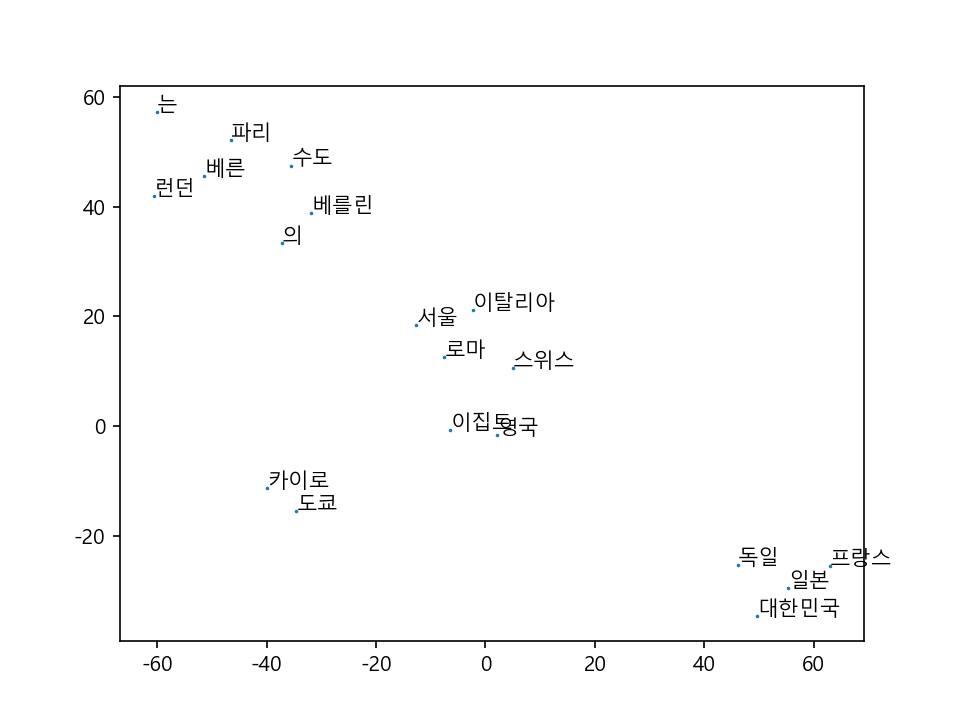

In [44]:
# Library import
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


# 간단한 Corpus
text = ['대한민국의 수도는 서울',
       '독일의 수도는 베를린',
       '프랑스의 수도는 파리',
       '스위스의 수도는 베른',
       '일본의 수도는 도쿄',
       '이탈리아의 수도는 로마',
       '영국의 수도는 런던',
       '이집트의 수도는 카이로'
       ]        

#parameters
emb_dim = 20
window_size = 2
n_negsam = 2
lr = 0.01
n_epoch = 1000

sentences, corpus, words, subs, vocab, vocab_sub, word_dict, index_dict, subs_dict, subs_index_dict = Prep().Get_clean(text) # 전처리
inputs, targets, labels = Make_pairs().Get_pairs(window_size, n_negsam) # Input / target / label 생성
center_mat, context_mat = train(inputs, targets, labels, emb_dim, lr, n_epoch) # Training
wordvec_2d = TSNEplot(context_mat.data, vocab, perplexity=4) # TNSE plotting

In [45]:
## Cos sim v2

import numpy as np
from numpy import dot
from numpy.linalg import norm

def cos_sim(word, n=10):
    all_sim = []
    
    subs = Word_to_sub(word) # sub word로 분해
    subs = [i for i in subs if i in list(subs_dict.keys())] # sub_dict에 있는 sub들만 취급
    
    x_sub = [subs_dict[i] for i in subs]
    h_sub = [center_mat[:,i] for i in x_sub] # look-up table
    h = sum(h_sub).detach().numpy() 
    
    # vocab의 단어들과 유사도 비교
    for v in vocab:
        vec = context_mat[word_dict[v],:].detach().numpy()
        sim = dot(h, vec)/(norm(h)*norm(vec))
        all_sim.append(sim)
    
    top = np.argsort(all_sim)[::-1][:n]
    outword = [index_dict[i] for i in top]
    outsim = [all_sim[t] for t in top]
    
    print('-------------------------------------')
    print('Cosine Similarity of Top %d words' % n)
    print('-------------------------------------')
    for i in range(n):
        print(outword[i] + ': ' + str(outsim[i]))
        
#     return outword, outsim

In [50]:
cos_sim('대한민국')

-------------------------------------
Cosine Similarity of Top 10 words
-------------------------------------
도쿄: -0.39816284
카이로: -0.42994073
로마: -0.47396323
이탈리아: -0.5039075
서울: -0.5090218
이집트: -0.51257205
수도: -0.5173976
대한민국: -0.53663915
스위스: -0.5396189
영국: -0.54011685
